#### This Notebook for explain How to use genetic algorithm for optimization to select the best features from cnn architecture like mobilenetv2 and make it more faster and more accurate and make calsification task using svm classifier


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation, concatenate, GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam


## Load Data

In [2]:
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle

# Load brain tumor detection dataset
input_path = r"C:\Users\purna\Downloads\New folder (2)\corona train"
yes = os.path.join(input_path, 'COVID')
no = os.path.join(input_path, 'non-COVID')

labels = ['COVID', 'Non-COVID']

# Load images
yes_list = os.listdir(yes)
no_list = os.listdir(no)


# Array to store images
X = []
y = []
IMG_SIZE = (128, 128)

# Load images with tumor
for i in range(len(yes_list)):
    file_path = os.path.join(yes, yes_list[i])

    if os.path.exists(file_path):
        img = plt.imread(file_path)
        img_resized = resize(img, IMG_SIZE + (3,))  # Ensure 3 channels for RGB
        X.append(img_resized)
        y.append(1)
    else:
        print(f"File not found: {file_path}")

# Load images without tumor
for i in range(len(no_list)):
    file_path = os.path.join(no, no_list[i])
    if os.path.exists(file_path):
        img = plt.imread(file_path)
        img_resized = resize(img, IMG_SIZE + (3,))  # Ensure 3 channels for RGB
        X.append(img_resized)
        y.append(0)
    else:
        print(f"File not found: {file_path}")

# Convert to numpy array
X = np.array(X)
y = np.array(y)

# Shuffle data
X, y = shuffle(X, y, random_state=42)


In [3]:
X.shape,y.shape

((2491, 128, 128, 3), (2491,))

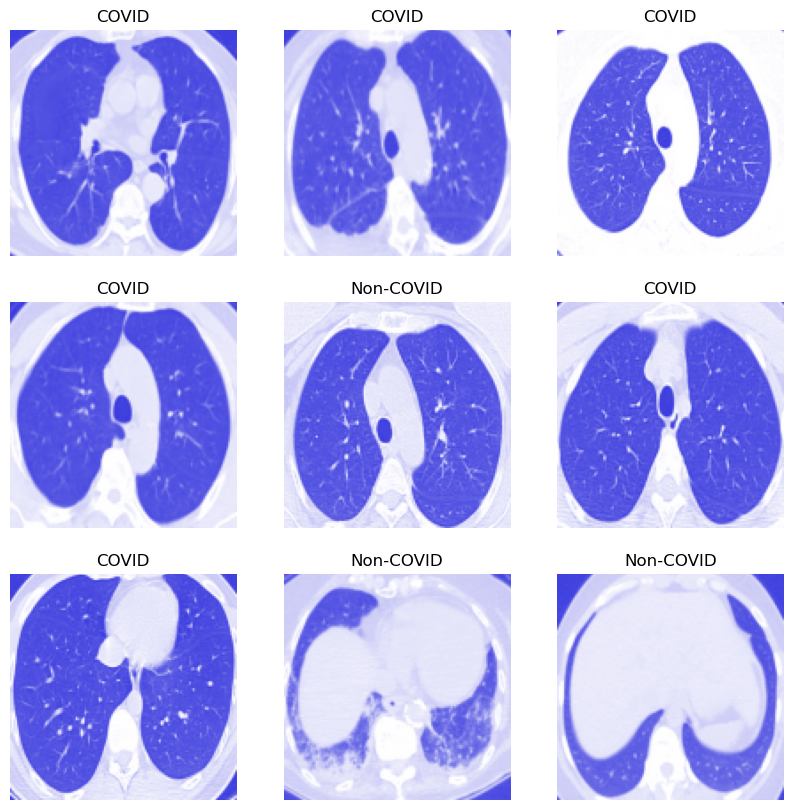

In [4]:
# plot some images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X[i])
    plt.title(labels[y[i]])
    plt.axis('off')

## Data Preparation

In [5]:
# split data into train and test 20% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# # normalize data
# X_train = X_train / 255
# X_test = X_test / 255

# one hot encode target
from keras.utils import to_categorical
y_train_to_categorical = to_categorical(y_train)
y_test_to_categorical = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train_to_categorical.shape, y_test_to_categorical.shape)

(1992, 128, 128, 3) (499, 128, 128, 3) (1992, 2) (499, 2)


In [6]:
from keras.applications import mobilenet_v2

# Load the MobileNetV2 model
mobile_net_v2_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D

# Your existing code for freezing layers
for layer in mobile_net_v2_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the MobileNetV2 model as the first layer
model.add(mobile_net_v2_model)

# Add a Global Average Pooling layer
model.add(GlobalAveragePooling2D())
model.summary()

# Add more custom layers as needed
# ...

# Compile the model and set up training parameters
# ...

# Train the model
# ...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 2257984 (8.61 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [8]:
feature_train = model.predict(X_train)
feature_test = model.predict(X_test)

16/16 [==============================] - 2s 150ms/step


In [9]:
print(feature_train.shape, feature_test.shape)

(1992, 1280) (499, 1280)


In [10]:
# Flatten extracted features
flat_train = feature_train.reshape(feature_train.shape[0], -1)
flat_test = feature_test.reshape(feature_test.shape[0], -1)

In [11]:
print(flat_train.shape, flat_test.shape)

(1992, 1280) (499, 1280)


In [12]:
y_train_flattened=y_train.ravel()
y_test_flattened=y_test.ravel()
y_train_flattened.shape,y_test_flattened.shape

((1992,), (499,))

## Genatic Algorithm
> is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms (EA). Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on biologically inspired operators such as mutation, crossover and selection.

In [13]:
# use genatic algorithm to find best features to use
from sklearn.svm import SVC
# Genetic Algorithm Parameters
POP_SIZE = 10
GENES = flat_train.shape[1]
GENERATIONS = 50
MUTATION_RATE = 0.01
CROSSOVER_RATE = 0.7
AVERAGE_ACC = [] # Average accuracy of each generation

# Initialize population
def initialize_population(population_size, genes):
    return np.random.choice([0, 1], size=(population_size, genes))

# Evaluate fitness using nn classifier
def evaluate_fitness(population, X_train, X_test, y_train, y_test):
    fitness_values = []
    for chromosome in population:
        selected_features = np.where(chromosome == 1)[0]
        if len(selected_features) == 0:
            fitness_values.append(0)
            continue
        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]
        model = SVC(kernel='poly', C=1)
        model.fit(X_train_selected, y_train)
        test_acc = model.score(X_test_selected, y_test)
        print('Acc:', test_acc)
        fitness_values.append(test_acc)

    return np.array(fitness_values)

# Perform crossover
def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# Perform mutation
def mutate(child):
    mutation_mask = np.random.rand(len(child)) < MUTATION_RATE
    child[mutation_mask] = 1 - child[mutation_mask]  # Flip the bits
    return child

# Main Genetic Algorithm
def genetic_algorithm(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    population = initialize_population(POP_SIZE, GENES)

    for generation in range(GENERATIONS):
        print(f'=========================================== generation:{generation} =========================================== ')
        fitness_values = evaluate_fitness(population, X_train, X_test, y_train, y_test)
        selected_indices = np.argsort(fitness_values)[::-1][:int(POP_SIZE * CROSSOVER_RATE)]

        new_population = []
        AVERAGE_ACC.append(np.mean(fitness_values))
        # Perform crossover and mutation
        for _ in range(0, POP_SIZE, 2):
            parent1 = population[np.random.choice(selected_indices)]
            parent2 = population[np.random.choice(selected_indices)]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_population.extend([child1, child2])

        population = np.array(new_population)

    best_individual = population[np.argmax(fitness_values)]
    selected_features = np.where(best_individual == 1)[0]
    return selected_features

# usage
selected_features = genetic_algorithm(flat_train, y_train_flattened)
print("Selected Features:", selected_features)

=========================================== generation:0 =========================================== 
Acc: 0.9122807017543859
Acc: 0.9072681704260651
Acc: 0.9172932330827067
Acc: 0.9197994987468672
Acc: 0.9147869674185464
Acc: 0.9097744360902256
Acc: 0.9047619047619048
Acc: 0.9122807017543859
Acc: 0.9147869674185464
Acc: 0.9172932330827067
=========================================== generation:1 =========================================== 
Acc: 0.9197994987468672
Acc: 0.9122807017543859
Acc: 0.9172932330827067
Acc: 0.9047619047619048
Acc: 0.9172932330827067
Acc: 0.9197994987468672
Acc: 0.9147869674185464
Acc: 0.9047619047619048
Acc: 0.9072681704260651
Acc: 0.9072681704260651
=========================================== generation:2 =========================================== 
Acc: 0.9172932330827067
Acc: 0.9122807017543859
Acc: 0.9172932330827067
Acc: 0.924812030075188
Acc: 0.9147869674185464
Acc: 0.924812030075188
Acc: 0.9122807017543859
Acc: 0.9197994987468672
Acc: 0.9122807017543859


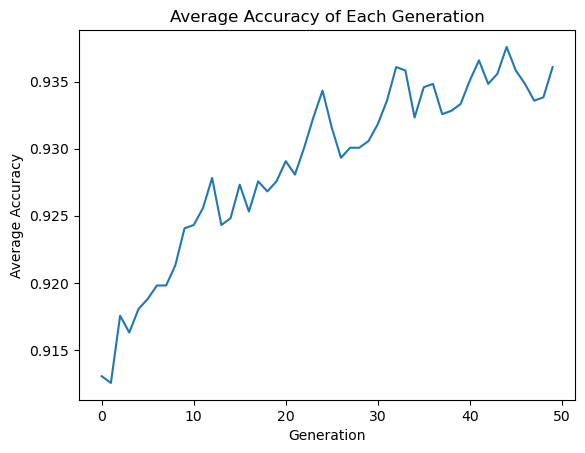

In [14]:
# plot the average accuracy of each generation
plt.plot(AVERAGE_ACC)
plt.xlabel('Generation')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy of Each Generation')
plt.show()

In [15]:
flat_train[:, selected_features].shape

(1992, 636)

In [16]:
flat_train_selected_features=flat_train[:, selected_features]
flat_test_selected_features=flat_test[:, selected_features]

## Tarin svm model on selected features

In [17]:
# tarin svm model on all features
model = SVC(kernel='poly', C=1)
model.fit(flat_train_selected_features, y_train)
test_acc = model.score(flat_test_selected_features, y_test)
print('Acc:', test_acc)

Acc: 0.9458917835671342


## Predictions on test data

(499,)


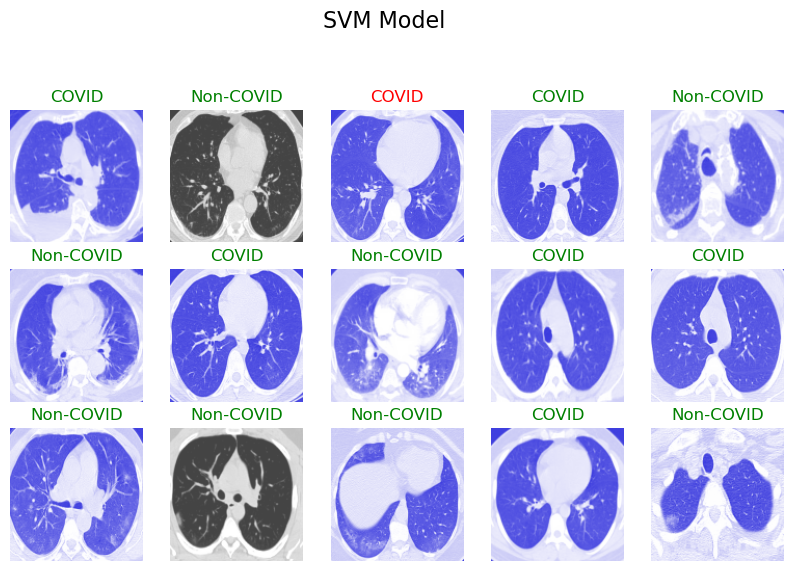

In [18]:
# predict on test data
predictions = model.predict(flat_test_selected_features)
print(predictions.shape)

# plot the results
plt.figure(figsize=(10,10))
for i in range(15):
    n=np.random.randint(0, len(predictions))
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[n])
    plt.title(f'{labels[predictions[n]]}',color="red" if y_test[n]!=predictions[n] else "green")
    plt.suptitle('SVM Model', fontsize=16)
    plt.axis('off')


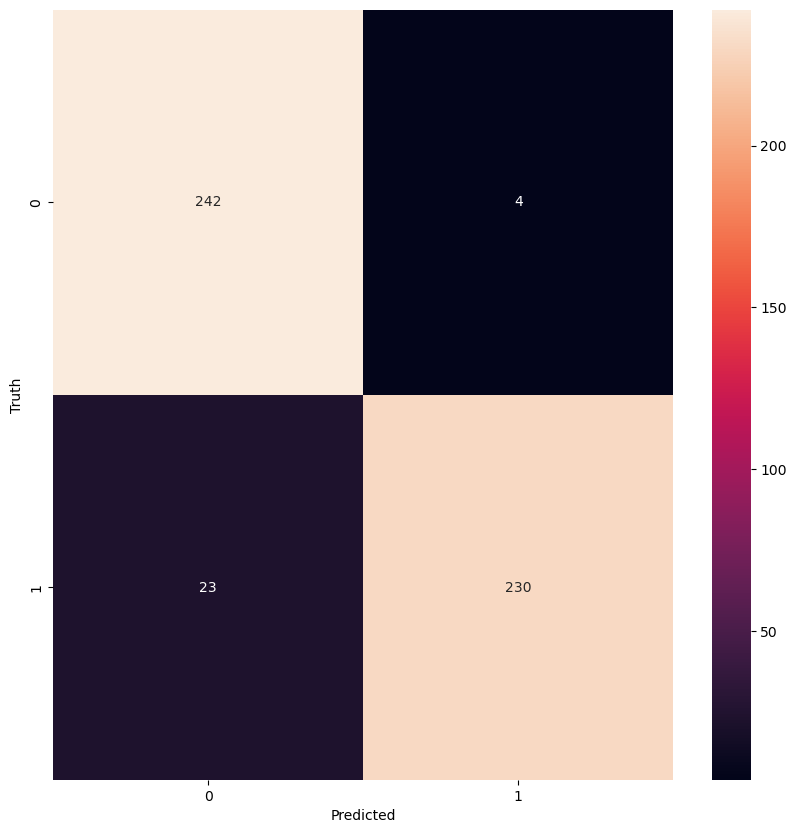

In [19]:
# confusion matrix
import seaborn as sns

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
# heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [20]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       246
           1       0.98      0.91      0.94       253

    accuracy                           0.95       499
   macro avg       0.95      0.95      0.95       499
weighted avg       0.95      0.95      0.95       499



In [21]:
# save model for svm
import pickle
pickle.dump(model, open('COVID DETECTION.sav', 'wb'))

from IPython.display import FileLink
FileLink(r'COVID DETECTION.sav')

C:\Users\purna\COVID DETECTION.sav

In [22]:
IMAGE_SIZE = 224

In [23]:
pip install scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.


In [24]:
from joblib import load

# Replace 'your_model_file.sav' with the actual filename
loaded_model = load(r'COVID DETECTION.sav')


In [25]:
from PIL import Image
import numpy as np

# Load the image
img = Image.open(r"C:\Users\purna\Downloads\New folder (2)\corona train\non-COVID\Non-Covid (22).png")

# Define the desired width and height
width, height = 224, 224  # Adjust according to your model's input size

# Example preprocessing steps (adjust according to your model's requirements)
img = img.resize((width, height))  # Resize to the model's input size
img_array = np.array(img)
img_array = img_array / 255.0  # Normalize pixel values (if your model expects values in the [0, 1] range)

# Flatten the image array if needed
img_flattened = img_array.flatten()


In [26]:
# Flatten the images
X_train_flattened = X_train.reshape((X_train.shape[0], -1))
X_test_flattened = X_test.reshape((X_test.shape[0], -1))

# Display the shapes
print(X_train_flattened.shape, X_test_flattened.shape)


(1992, 49152) (499, 49152)


In [27]:
from sklearn.svm import SVC

# Create an SVM model
svm_model = SVC(kernel='linear', C=1.0)

# Train the model
svm_model.fit(X_train_flattened, y_train)


SVC(kernel='linear')

The predicted class is: Non-COVID


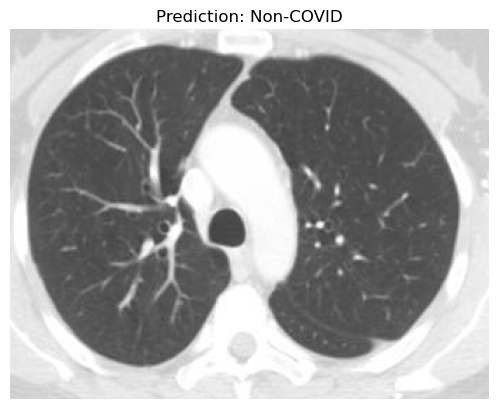

In [31]:
from skimage.transform import resize
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for displaying the image

# Load and preprocess the single image
image_path = r"C:\Users\purna\Downloads\New folder (2)\corona train\non-COVID\Non-Covid (306).png"  # Replace with the actual path
img = plt.imread(image_path)
img_resized = resize(img, (128, 128, 3))  # Resize and ensure 3 channels for RGB
img_flattened = img_resized.flatten()

# Make predictions
prediction = svm_model.predict([img_flattened])

# Map numeric prediction to class name
class_mapping = {0: 'Non-COVID', 1: 'COVID'}
predicted_class = class_mapping[int(prediction[0])]

# Display the prediction
print(f"The predicted class is: {predicted_class}")

plt.title('Prediction: {}'.format(predicted_class))  # Update this line with the correct predicted class
plt.imshow(img)  # Display the image
plt.axis('off')  # Turn off axis
plt.show()  # Show the plot


In [29]:
# Make predictions on the test set
predictions = svm_model.predict(X_test_flattened)

# Display the predictions
print(predictions)


[0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0
 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1
 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0
 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1
 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1
 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1
 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0
 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0
 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1
 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1
 0 0 0 1 0 1 1 0 0 1 1 1 